Epoch: 0, Loss: 0.036528002470731735
Epoch: 1, Loss: 0.02556329220533371
Epoch: 2, Loss: 0.020777039229869843
Epoch: 3, Loss: 0.017944425344467163
Epoch: 4, Loss: 0.016020141541957855
Epoch: 5, Loss: 0.014604249969124794
Epoch: 6, Loss: 0.013506483286619186
Epoch: 7, Loss: 0.012623288668692112
Epoch: 8, Loss: 0.011892879381775856
Epoch: 9, Loss: 0.011275766417384148
Epoch: 10, Loss: 0.010745452716946602
Epoch: 11, Loss: 0.010283339768648148
Epoch: 12, Loss: 0.009875964373350143
Epoch: 13, Loss: 0.00951333437114954
Epoch: 14, Loss: 0.009187818504869938
Epoch: 15, Loss: 0.00889348890632391
Epoch: 16, Loss: 0.008625692687928677
Epoch: 17, Loss: 0.008380645886063576
Epoch: 18, Loss: 0.008155315183103085
Epoch: 19, Loss: 0.00794718787074089
Epoch: 20, Loss: 0.0077541908249258995
Epoch: 21, Loss: 0.007574566174298525
Epoch: 22, Loss: 0.007406850811094046
Epoch: 23, Loss: 0.007249775808304548
Epoch: 24, Loss: 0.007102261297404766
Epoch: 25, Loss: 0.006963394116610289
Epoch: 26, Loss: 0.006832

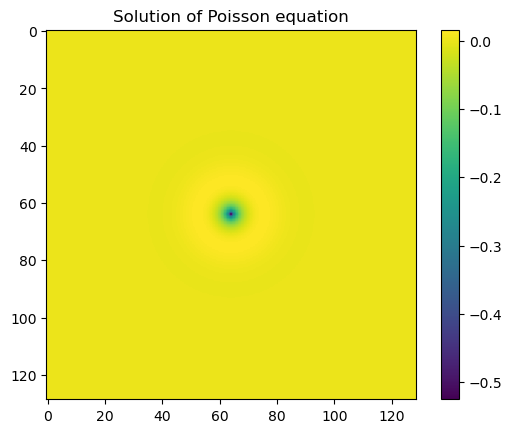

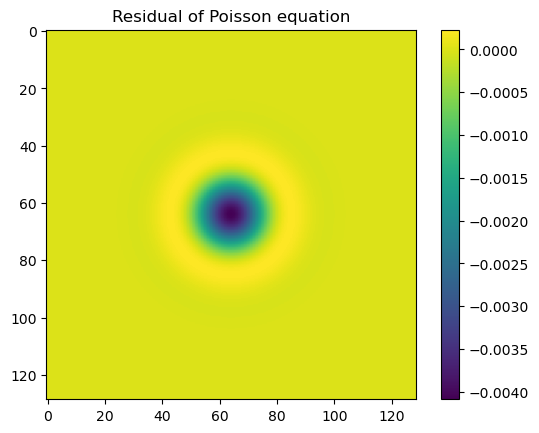

In [80]:
import jax
import jax.numpy as jnp
from jax import lax

# Define the Poisson equation function
def poisson_eqn(u, f):
    x = jnp.arange(0, u.shape[0])
    y = jnp.arange(0, u.shape[1])
    x, y = jnp.meshgrid(x, y)

    bound = (x == 0) | (x == u.shape[0]-1) | (y == 0) | (y == u.shape[1]-1)

    def poisson_eqn_single(val):
        i, j, b = val
        return b * u[i, j] + (1 - b) * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - 4 * u[i, j] - f[i, j])
    
    return jax.lax.map(poisson_eqn_single, (x, y, bound))

def poisson_loss(u, f):
    return jnp.sum(jnp.square(poisson_eqn(u, f)))

def poisson_loss_grad(u, f):
    return jax.grad(poisson_loss)(u, f)

def poisson_optimization(u, f, lr=0.01, epoch=10, num_iters=100):
    def body_fn(val):
        i, u, lr = val
        grad = poisson_loss_grad(u, f)
        u = u - lr * grad
        return i + 1, u

    def cond_fn(val):
        i, u = val
        return i < num_iters

    for i in range(epoch):
        _, u = lax.while_loop(cond_fn, body_fn, (0, u, lr))
        print('Epoch: {}, Loss: {}'.format(i, poisson_loss(u, f)))
    return u

# Define the 2D Jacobi iterative solver function
def jacobi_solver(u, f, epoch=10, num_iters=50):
    x = jnp.arange(0, u.shape[0])
    y = jnp.arange(0, u.shape[1])
    x, y = jnp.meshgrid(x, y)

    bound = (x == 0) | (x == u.shape[0]-1) | (y == 0) | (y == u.shape[1]-1)

    def jacobi_iteration(i, j, b):
        return b * u[i, j] + (1 - b) * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - f[i, j])*0.25

    for i in range(epoch):
        for _ in range(num_iters):
            u = jax.vmap(jacobi_iteration)(x, y, bound)
        print('Epoch: {}, Residual: {}'.format(i, jnp.sum(jnp.abs(poisson_eqn(u, f, h)))))

    return u



# Set up the problem parameters
nx = 129
ny = 129

x = jnp.arange(0, nx)
y = jnp.arange(0, ny)
x, y = jnp.meshgrid(x, y)

# Initialize the solution u
u = jnp.zeros((nx, ny))

# Initialize the source f
f = jnp.zeros((nx, ny))
f = f.at[64, 64].set(1)

# Solve the Poisson equation using Jacobi iterative solver
u = poisson_optimization(u, f, epoch=150, num_iters=100)

# Verify the solution satisfies the Poisson equation
residual = poisson_eqn(u, f)

# plot the solution
import matplotlib.pyplot as plt
plt.imshow(u)
plt.colorbar()
#set title
plt.title('Solution of Poisson equation')
plt.show()

# plot the residual
plt.imshow(residual)
plt.colorbar()
#set title
plt.title('Residual of Poisson equation')
plt.show()



Epoch: 0, Loss: 0.010745451785624027
Epoch: 1, Loss: 0.010283336043357849
Epoch: 2, Loss: 0.00987595971673727
Epoch: 3, Loss: 0.009513333439826965
Epoch: 4, Loss: 0.009187823161482811
Epoch: 5, Loss: 0.008893492631614208
Epoch: 6, Loss: 0.008625691756606102
Epoch: 7, Loss: 0.0083806486800313
Epoch: 8, Loss: 0.00815531238913536
Epoch: 9, Loss: 0.00794718973338604


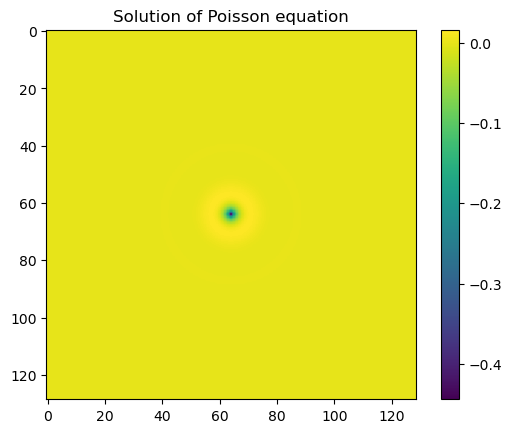

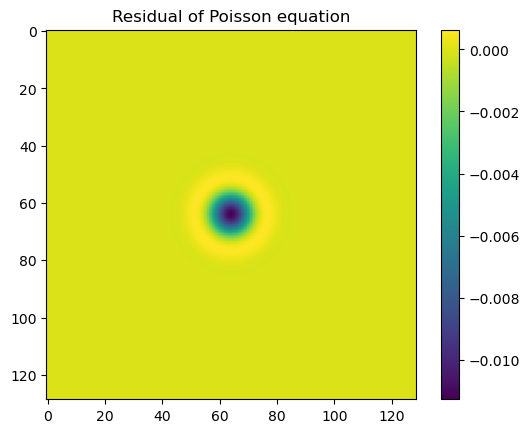

In [65]:
# Solve the Poisson equation using Jacobi iterative solver
u = poisson_optimization(u, f, 1, epoch=10, num_iters=100)

# Verify the solution satisfies the Poisson equation
residual = poisson_eqn(u, f, h)

# plot the solution
import matplotlib.pyplot as plt
plt.imshow(u)
plt.colorbar()
#set title
plt.title('Solution of Poisson equation')
plt.show()

# plot the residual
plt.imshow(residual)
plt.colorbar()
#set title
plt.title('Residual of Poisson equation')
plt.show()

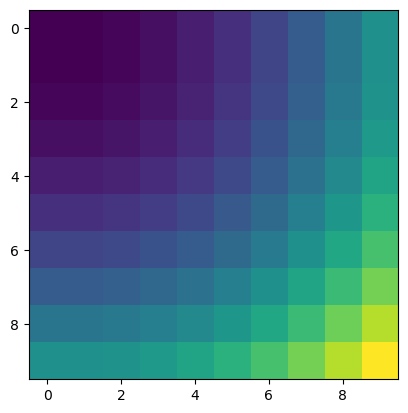

In [17]:
import jax
import jax.numpy as jnp

# create a meshgrid of x and y values
x = jnp.arange(0, 10)
y = jnp.arange(0, 10)
x, y = jnp.meshgrid(x, y)

# create a batch of input values
u = (x - 0.5)**2 + (y - 0.5)**2

def f(i, j):
    return u[i,j] + 0*i + 0*j

# Apply the function f to the batch of input values using vmap
f_batch = jax.vmap(f)(x, y)

# plot the results
import matplotlib.pyplot as plt
plt.imshow(f_batch)
plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F


laplacian_filter = torch.tensor([
    [0, 1, 0], [1, -4, 1], [0, 1, 0]
], dtype=torch.float32)

def poisson_eqn(b, u, f):
    return b * u + (1 - b) * (F.conv2d(
        u[None, None], laplacian_filter[None, None], padding=1
    ) - f)

nx, ny = 129, 129
u = nn.Parameter(torch.zeros(ny, nx))
f = torch.zeros(ny, nx)
b = torch.zeros(ny, nx)
f[64, 64] = 1

lr = 0.0001
optim = torch.optim.SGD([u], lr=lr)
prev_loss = 1e10

for i in range(3000):
    for j in range(100):
        optim.zero_grad()
        loss = poisson_eqn(b, u, f).pow(2).sum()
        loss.backward()
        optim.step()
        if loss.item() > prev_loss:
            lr *= 0.99
        else:
           lr *= 1.005
        prev_loss = loss.item()
        optim.param_groups[0]['lr'] = lr
    print('Epoch: {}, Loss: {}, lr: = {}'.format(i, loss, lr))
  

# Verify the solution satisfies the Poisson equation
residual = poisson_eqn(b, u, f)

Epoch: 0, Loss: 0.47483640909194946, lr: = 0.00016466684921165282
Epoch: 1, Loss: 0.25772345066070557, lr: = 0.0002711517122929321
Epoch: 2, Loss: 0.1611444652080536, lr: = 0.000446496981216217
Epoch: 3, Loss: 0.11178785562515259, lr: = 0.0007352325107938897
Epoch: 4, Loss: 0.08166848868131638, lr: = 0.0012106842099040228
Epoch: 5, Loss: 0.06116311624646187, lr: = 0.0019935955423519463
Epoch: 6, Loss: 0.04644453153014183, lr: = 0.003282790965614911
Epoch: 7, Loss: 0.035565540194511414, lr: = 0.005405668449282868
Epoch: 8, Loss: 0.027381103485822678, lr: = 0.0089013439142625
Epoch: 9, Loss: 0.02115480601787567, lr: = 0.014657562561109257
Epoch: 10, Loss: 173.3980255126953, lr: = 0.015605323804837447
Epoch: 11, Loss: 29.01883888244629, lr: = 0.015644451598079333
Epoch: 12, Loss: 18.239028930664062, lr: = 0.015683677497853515
Epoch: 13, Loss: 5.23156213760376, lr: = 0.015488330082233446
Epoch: 14, Loss: 2.2694947719573975, lr: = 0.01576242460155983
Epoch: 15, Loss: 0.7064664959907532, lr:

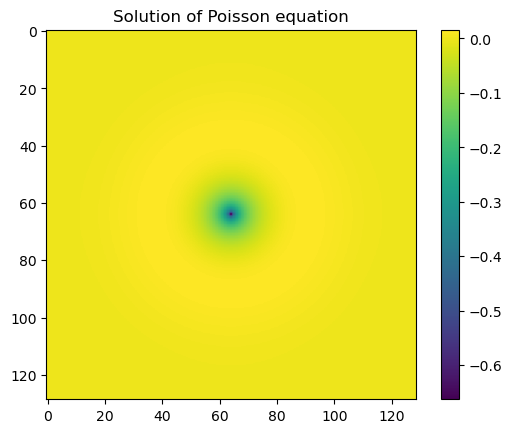

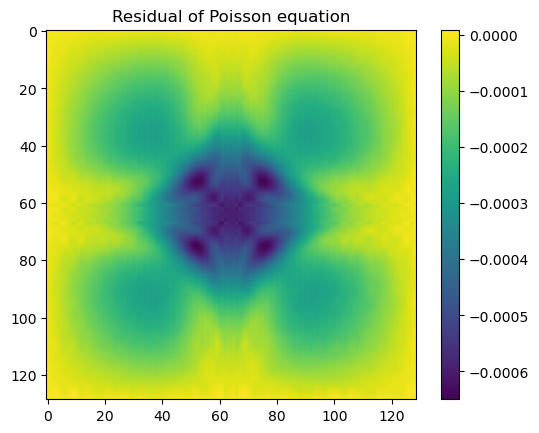

In [41]:
# plot the solution
import matplotlib.pyplot as plt
plt.imshow(u.detach().numpy())
plt.colorbar()
#set title
plt.title('Solution of Poisson equation')
plt.show()

# plot the residual
# reshape the residual to 2D
residual = residual.reshape(ny, nx)
plt.imshow(residual.detach().numpy())
plt.colorbar()
#set title
plt.title('Residual of Poisson equation')
plt.show()


In [40]:
#separable solution
nx, ny = 129, 129

# components of the solution
nr = 14

# initialize the separable solution u
ux = nn.Parameter(0.1 + 0.01 * torch.randn(nx, nr)) 
uy = nn.Parameter(0.1 + 0.01 * torch.randn(ny, nr))

# initialize the source f
f = torch.zeros(ny, nx)

# initialize the boundary conditions
b = torch.zeros(ny, nx)
f[64, 64] = 1

def solution_estimate(ux, uy):
    # compute the solution estimate
    u = ux @ uy.T
    return u

lr = 0.0001
optim = torch.optim.SGD([ux, uy], lr=lr)
prev_loss = 1e10

for i in range(3000):
    for j in range(100):
        optim.zero_grad()
        loss = poisson_eqn(b, solution_estimate(ux, uy), f).pow(2).sum()
        loss.backward()
        optim.step()
        if loss.item() > prev_loss:
            lr *= 0.99
        else:
           lr *= 1.005
        prev_loss = loss.item()
        optim.param_groups[0]['lr'] = lr
    print('Epoch: {}, Loss: {}, lr: = {}'.format(i, loss, lr))
  

# Verify the solution satisfies the Poisson equation
residual = poisson_eqn(b, solution_estimate(ux, uy), f)

Epoch: 0, Loss: 2.9483678340911865, lr: = 0.00016466684921165282
Epoch: 1, Loss: 1.9650452136993408, lr: = 0.0002711517122929321
Epoch: 2, Loss: 1.5661259889602661, lr: = 0.000446496981216217
Epoch: 3, Loss: 1.3405367136001587, lr: = 0.0007352325107938897
Epoch: 4, Loss: 1.1220978498458862, lr: = 0.0012106842099040228
Epoch: 5, Loss: 0.627945065498352, lr: = 0.0019935955423519463
Epoch: 6, Loss: 0.27436408400535583, lr: = 0.003282790965614911
Epoch: 7, Loss: 3.1075994968414307, lr: = 0.004001585143707848
Epoch: 8, Loss: 0.1858585625886917, lr: = 0.004324878958175037
Epoch: 9, Loss: 0.12559324502944946, lr: = 0.004401415654700218
Epoch: 10, Loss: 0.09844227135181427, lr: = 0.004412451483489322
Epoch: 11, Loss: 0.08685308694839478, lr: = 0.004423514982811412
Epoch: 12, Loss: 0.07720949500799179, lr: = 0.00450179722541015
Epoch: 13, Loss: 0.0716339573264122, lr: = 0.00444572527074583
Epoch: 14, Loss: 0.06553953886032104, lr: = 0.00452440056528517
Epoch: 15, Loss: 0.06031211465597153, lr: 